Function: Used this notebook to find the dementia-cv risk quantiles where most of a population is. This will help us narrow the part of the dementia-cv quantile area that we use in trials. This notebook was used first and then followed by findZeroAbsEffectSizes to further narrow the part of the risk quantiles area we use in trials.

In [51]:
#%matplotlib qt

In [1]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandarallel import pandarallel
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt

In [49]:
%matplotlib notebook
%matplotlib inline
%autosave 120

Autosaving every 120 seconds


In [3]:
from microsim.bp_treatment_strategies import *

from microsim.outcome_model_repository import OutcomeModelRepository
from microsim.outcome_model_type import OutcomeModelType
from microsim.person import Person

from microsim.population import NHANESDirectSamplePopulation

from microsim.bp_treatment_strategies import SprintTreatment

from microsim.sim_settings import simSettings

from microsim.trials.trialset import TrialsetParallel, TrialsetSerial
from microsim.trials.trial_description import TrialDescription
from microsim.trials.logistic_regression_analysis import LogisticRegressionAnalysis
from microsim.trials.linear_regression_analysis import LinearRegressionAnalysis
from microsim.trials.outcome_assessor import OutcomeAssessor
from microsim.trials.attribute_outcome_assessor import AttributeOutcomeAssessor
from microsim.trials.attribute_outcome_assessor import AssessmentMethod
from microsim.trials.risk_filter import RiskFilter
from microsim.trials.trial_utils import get_analysis_name, randomizationSchema

In [7]:
#any microsim dir will work, just need to access the NHANES data
#microsimDir = "/users/PAS2164/deligkaris/MICROSIM/CODE/microsim"
microsimDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/CODE/microsim"
os.chdir(microsimDir)
imputedDataset = pd.read_stata(microsimDir + "/microsim/data/fullyImputedDataset.dta")
dataDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/NOTEBOOKS/DATA"

In [5]:
#at the beginning turn on pandarallel if you are planning to use TrialsetSerial
pandarallel.initialize(verbose=1) #microsim by default now does not initialize pandarallel
simSettings.pandarallelFlag = True #with this flag all new population instances will be set to use pandarallel

In [6]:
%%time
#with pandarallel on these two steps are faster
#12min with 10,000, 22min with 20,000, 61min with 60,000, 102min with 100,000, 160min with 150,000
#osc: 27min with 10,000
pop = NHANESDirectSamplePopulation(150000, 1999)
alive, df = pop.advance_vectorized(200)

/Users/deligkaris.1/Library/Caches/pypoetry/virtualenvs/microsim-54NoInYP-py3.9/lib/python3.9/site-packages/pandarallel/data_types/series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/gfr_equation.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine / crThreshold) ** exponent * 0.993**x.age
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/gfr_equation.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine / crThreshold)

CPU times: user 1h 54min 39s, sys: 9min 41s, total: 2h 4min 20s
Wall time: 2h 38min 42s


In [14]:
#import pickle
#import json
#with open(dataDir+"/pop-150k-usualCare.json", 'w') as handle:
#    pickle.dump(pop, handle, protocol=pickle.HIGHEST_PROTOCOL)
#    json.dump(pop.__dict__, handle)

In [15]:
def getDFForPersonCol(person):
    df = pd.DataFrame(person.get_final_wave_state_as_dict())
    df['dfIndex'] = person.dfIndex
    df['cvRisk'] = df.apply(OutcomeModelRepository().get_risk_for_person, args=(OutcomeModelType.CARDIOVASCULAR, 1, True), axis='columns')
    df['demRisk'] = df.apply(OutcomeModelRepository().get_risk_for_person,  args=(OutcomeModelType.DEMENTIA, 1, True), axis='columns')
    return df

dfs = pop._people.apply(getDFForPersonCol)

In [16]:
allAgesDF = pd.concat(dfs.tolist())

In [ ]:
#allAgesDF.head()

In [ ]:
#allAgesDF = allAgesDF.loc[allAgesDF.totalYearsInSim == 1]

In [ ]:
#allAgesDF.loc[allAgesDF.demRisk > 1, 'demRisk'].count(), allAgesDF.loc[allAgesDF.demRisk > 1, 'demRisk']

In [18]:
allAgesDF.loc[allAgesDF.demRisk > 1, 'demRisk'] = 1

In [20]:
#allAgesDF.demRisk.describe(), allAgesDF.cvRisk.describe()

In [ ]:
#if some points are outside of the min and max of this then qcut will return them to belong in NaN
#np.arange(increment, 1.0, increment)

In [ ]:
#we need to have n+1 points in order to have n intervals
#len(np.arange(increment, 1.0, increment)),len(np.arange(0, 1.0, increment)),len(np.arange(0, 1.0+increment, increment))

In [21]:
nQuantiles = 40
increment = 1.0/nQuantiles
#qcut will move the left boundary to a value lower than the min, so that the left end (which is open)
#will include the min
allAgesDF['demRiskQuantile'] = pd.qcut(allAgesDF.demRisk, np.arange(0, 1.0+increment, increment))
allAgesDF['cvRiskQuantile'] = pd.qcut(allAgesDF.cvRisk, np.arange(0, 1.0+increment, increment))

In [ ]:
#allAgesDF.shape

In [ ]:
#allAgesDF['cvRiskQuantile'].head(50)

In [22]:
#there should not be any NaNs
allAgesDF['demRiskQuantile'].isna().sum(), allAgesDF['cvRiskQuantile'].isna().sum()

(0, 0)

In [23]:
meanDemRiskForQuantile = allAgesDF.groupby('demRiskQuantile')['demRisk'].mean()
meanCVRiskForQuantile = allAgesDF.groupby('cvRiskQuantile')['demRisk'].mean()

meanDemRiskForQuantileDict = {index : value for index, value in meanDemRiskForQuantile.items()}
meanCVRiskForQuantileDict = {index : value for index, value in meanCVRiskForQuantile.items()}

demQuantileNumberForQuantile = {quantile : index for index, quantile 
                                in enumerate(allAgesDF['demRiskQuantile'].value_counts(sort=False).index)}
cvQuantileNumberForQuantile = {quantile : index for index, quantile 
                               in enumerate(allAgesDF['cvRiskQuantile'].value_counts(sort=False).index)}

demQuantileForNumber = {index : quantile for index, quantile 
                        in enumerate(allAgesDF['demRiskQuantile'].value_counts(sort=False).index)}
cvQuantileForNumber = {index : quantile for index, quantile 
                       in enumerate(allAgesDF['cvRiskQuantile'].value_counts(sort=False).index)}

In [ ]:
#allAgesDF['cvRiskQuantile'].value_counts(sort=False).index

In [ ]:
#demQuantileNumberForQuantile

In [ ]:
#allAgesDF['demRiskQuantile'].value_counts().index

In [ ]:
#meanDemRiskForQuantile, meanDemRiskForQuantileDict, demQuintileNumberForQuantile

In [24]:
allAgesDF['meanDemRiskForQuantile'] = allAgesDF['demRiskQuantile']
allAgesDF['meanDemRiskForQuantile'].replace(meanDemRiskForQuantileDict, inplace=True)
allAgesDF['meanCVRiskForQuantile'] = allAgesDF['cvRiskQuantile']
allAgesDF['meanCVRiskForQuantile'].replace(meanCVRiskForQuantileDict, inplace=True)

allAgesDF['cvQuantileNum'] = allAgesDF['cvRiskQuantile']
allAgesDF['cvQuantileNum'].replace(cvQuantileNumberForQuantile, inplace=True)

allAgesDF['demQuantileNum'] = allAgesDF['demRiskQuantile']
allAgesDF['demQuantileNum'].replace(demQuantileNumberForQuantile, inplace=True)

In [ ]:
### next step is to see how this varies by age...
### if we have wide distribution, then we can just go through deciles or something like that for trial sampling!

In [ ]:
#allAgesDF.groupby(['cvQuantileNum', 'demQuantileNum'])['age'].count()

In [25]:
countByRisks = allAgesDF.groupby(['cvQuantileNum', 'demQuantileNum'],sort=True
                                )['age'].count().unstack(fill_value=0).stack()
#countByRisks

In [ ]:
#countByRisks = allAgesDF.groupby(['cvQuantileNum', 'demQuantileNum'],sort=False
#                                )['age'].count().unstack(fill_value=0).stack()
#countByRisks

In [26]:
countByRisksDF = pd.DataFrame({'demRisk' : countByRisks.index.get_level_values(0),
                              'cvRisk' : countByRisks.index.get_level_values(1),
                              'ageCount' : countByRisks.values})
#countByRisksDF

In [ ]:
#allAgesDF['dfIndex'].nunique()

In [ ]:
#allAgesDF.loc[(allAgesDF.demQuantileNum==5) & (allAgesDF.cvQuantileNum==5),"dfIndex"]

In [ ]:
#allAgesDF.groupby(['cvQuantileNum', 'demQuantileNum'],sort=False)['dfIndex'].nunique()

In [ ]:
#allAgesDF.groupby(['cvQuantileNum', 'demQuantileNum'],sort=False)['dfIndex'].nunique().unstack(fill_value=0)

In [27]:
countIndexByRisks = allAgesDF.groupby(['cvQuantileNum', 'demQuantileNum'],sort=False
                                )['dfIndex'].nunique().unstack(fill_value=0).stack()

In [28]:
countIndexByRisksDF = pd.DataFrame({'demRisk' : countIndexByRisks.index.get_level_values(0),
                              'cvRisk' : countIndexByRisks.index.get_level_values(1),
                              'indexCount' : countIndexByRisks.values})
#countIndexByRisksDF

In [29]:
#used in plots later
X=np.arange(0,nQuantiles,1)
Y=np.arange(0,nQuantiles,1)
X, Y = np.meshgrid(X, Y)
X.shape

(40, 40)

In [30]:
#this is done just in case the quantile categories are not ordered properly
countByRisksArray=np.zeros(X.shape)
for i,j,k in zip(countByRisksDF["demRisk"].values,countByRisksDF["cvRisk"].values,countByRisksDF["ageCount"].values):
    countByRisksArray[i,j]=k
#countByRisksArray

In [31]:
#this is done just in case the quantile categories are not ordered properly
countIndexByRisksArray=np.zeros(X.shape)
for i,j,k in zip(countIndexByRisksDF["demRisk"].values,countIndexByRisksDF["cvRisk"].values,countIndexByRisksDF["indexCount"].values):
    countIndexByRisksArray[i,j]=k
#countByRisksArray

In [32]:
ageCountSum = countByRisksDF["ageCount"].sum() #sum of all person-ages
ageCountSumPerQbox = ageCountSum/(nQuantiles)/(nQuantiles) # of person-ages in one qq category, uniform ditribution
ageCountSum, ageCountSumPerQbox

(6062319, 3788.949375)

In [40]:
indexCountSum = countIndexByRisksDF["indexCount"].sum() #sum of all person-ages
indexCountSumPerQbox = indexCountSum/(nQuantiles)/(nQuantiles) # of person-ages in one qq category, uniform ditribution
indexCountSum, indexCountSumPerQbox

(1275894, 797.4337499999999)

In [33]:
percentCutoff = 0.5 #relevant to a uniform distribution, which qq categories to keep
cutoff = (ageCountSumPerQbox * percentCutoff)
cutoff

1894.4746875

In [71]:
percentCutoffIndex = 0.5 #relevant to a uniform distribution, which qq categories to keep
cutoffIndex = (indexCountSumPerQbox * percentCutoffIndex)
cutoffIndex

398.71687499999996

In [176]:
qqcategoriesToInclude = countByRisksDF.loc[countByRisksDF["ageCount"] > cutoff] 
#qqcategoriesToInclude, 
qqcategoriesToInclude["ageCount"].sum()/ageCountSum #percent of person-ages included

0.9527456407358307

In [177]:
qqcategoriesToIncludeIndex = countIndexByRisksDF.loc[countIndexByRisksDF["indexCount"] > cutoffIndex] 
#qqcategoriesToInclude, 
qqcategoriesToIncludeIndex["indexCount"].sum()/indexCountSum #percent of person-ages included

0.953722644671109

In [35]:
#if demRisk and cvRisk are not ordered correctly, this does not work...
#countByRisksDF['ageCount'].to_numpy().reshape(nQuantiles-0, nQuantiles-0) >5000 

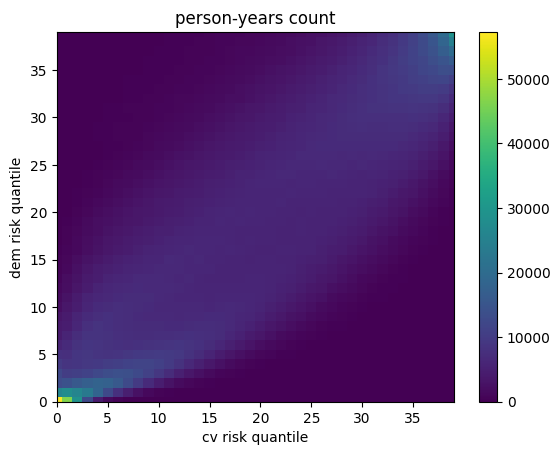

In [36]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, countByRisksArray, shading='nearest')
ax.set_title('person-years count')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

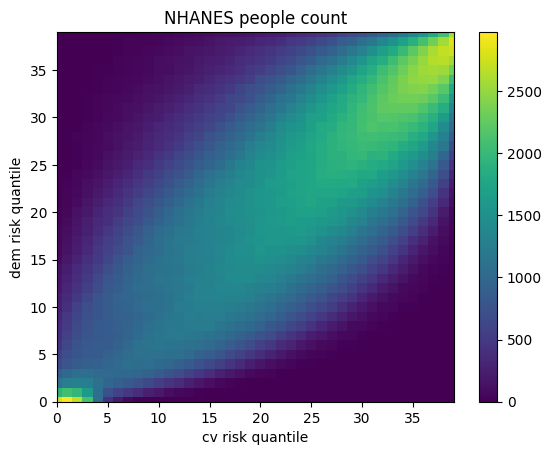

In [37]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, countIndexByRisksArray, shading='nearest')
ax.set_title('NHANES people count')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

In [133]:
# decide on which quantiles to keep
included = np.zeros(X.shape)

for i, j in zip(qqcategoriesToInclude["demRisk"],qqcategoriesToInclude["cvRisk"]):
    included[i,j]=1
    
#included

In [65]:
# decide on which quantiles to keep
includedIndex = np.zeros(X.shape)

for i, j in zip(qqcategoriesToIncludeIndex["demRisk"],qqcategoriesToIncludeIndex["cvRisk"]):
    includedIndex[i,j]=1
    
#included

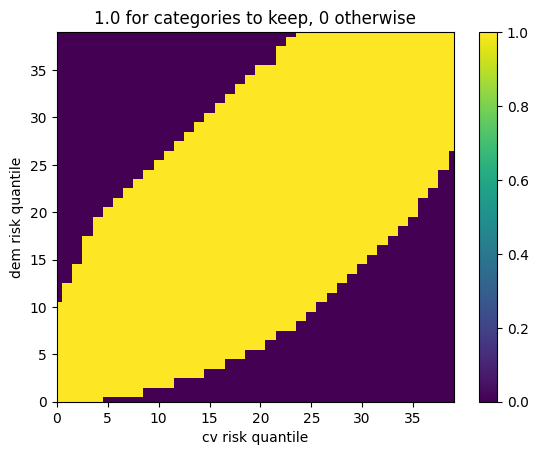

In [39]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, included, shading='nearest')
ax.set_title('1.0 for categories to keep, 0 otherwise')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

<IPython.core.display.Javascript object>


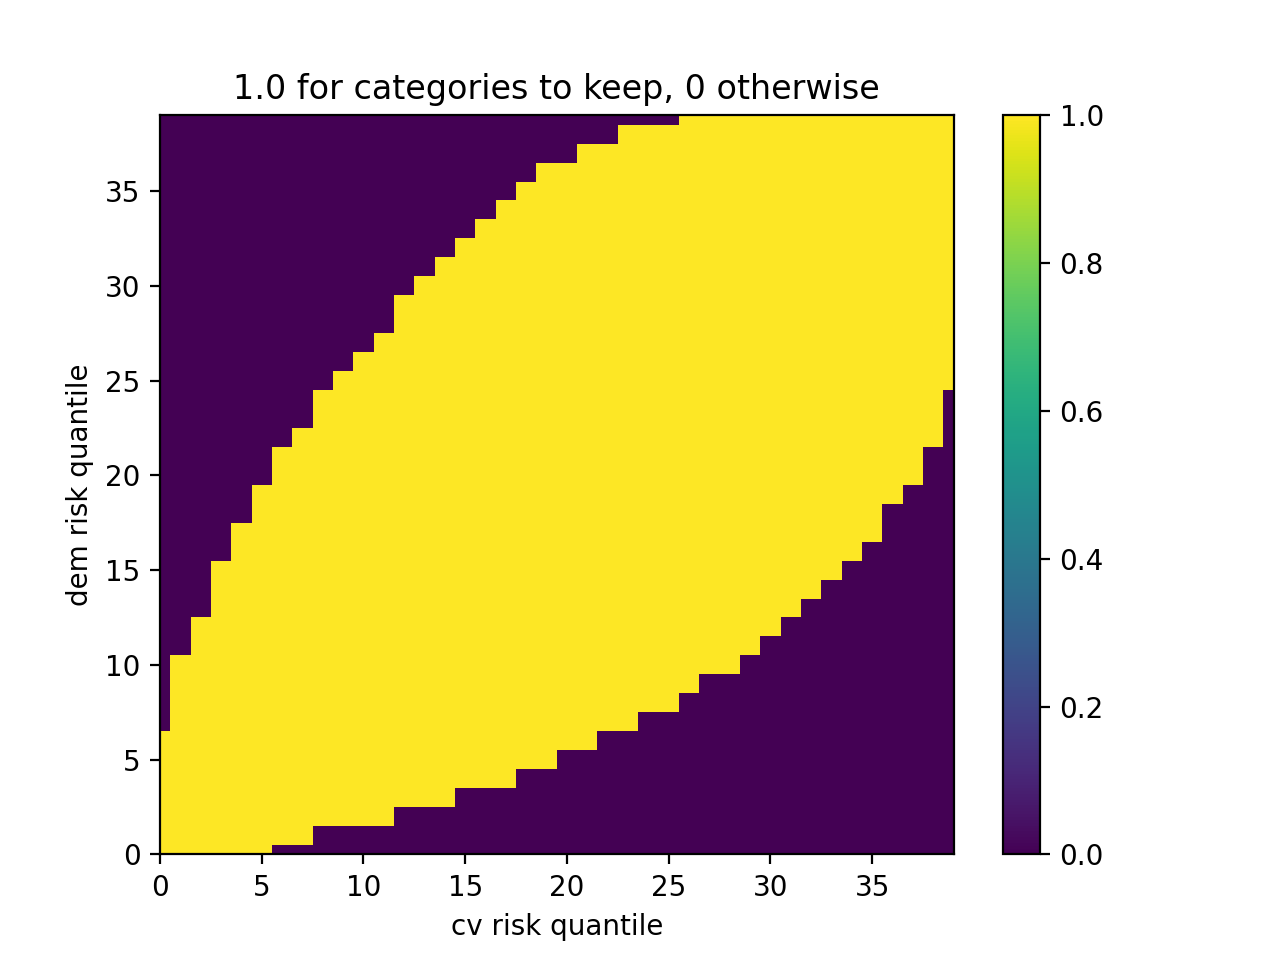

In [73]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, includedIndex, shading='nearest')
ax.set_title('1.0 for categories to keep, 0 otherwise')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

In [45]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [46]:
ax = Axes3D(fig)

<IPython.core.display.Javascript object>


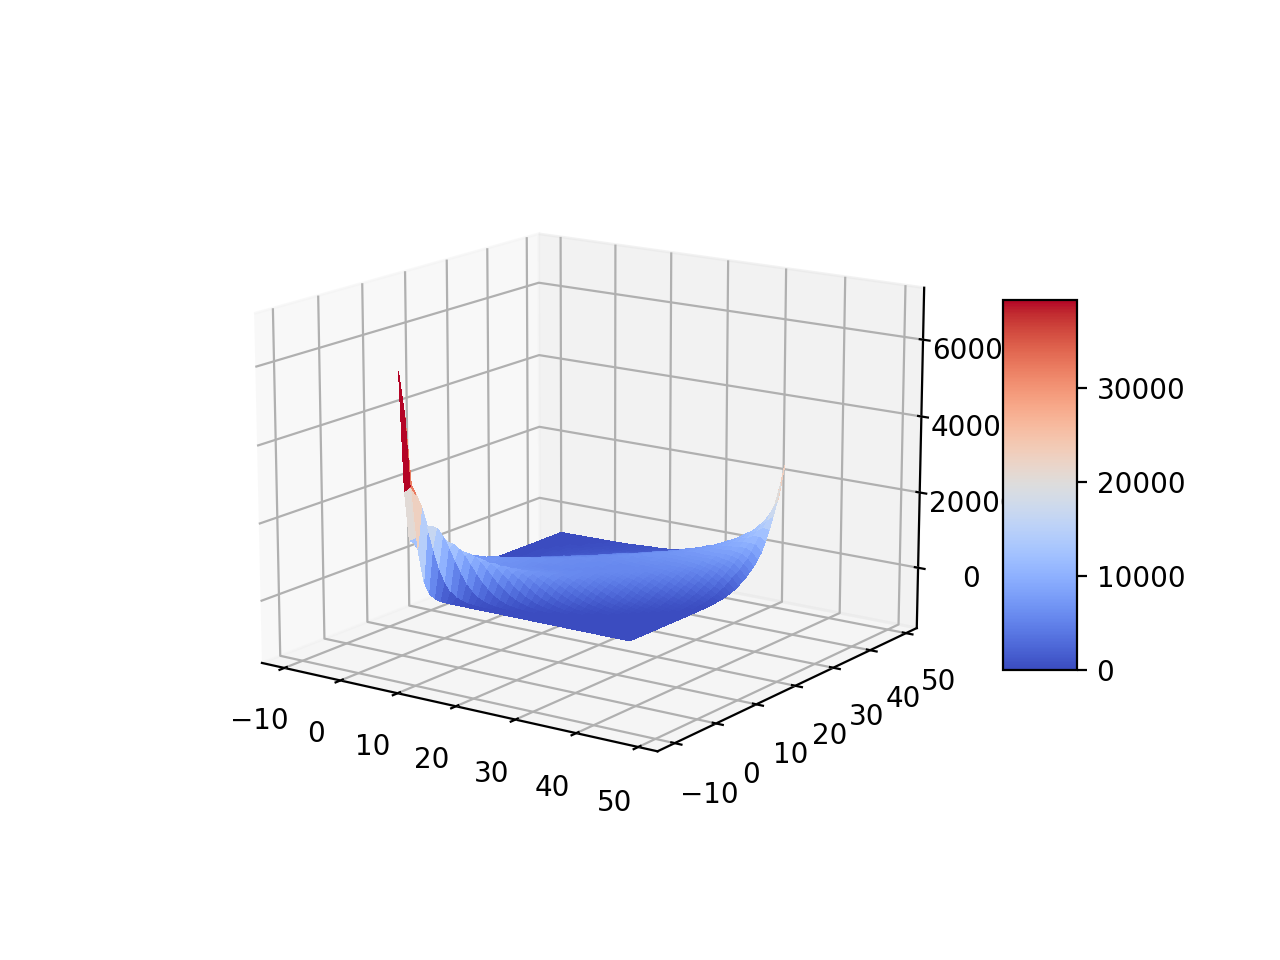

In [52]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, countByRisksArray, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

<IPython.core.display.Javascript object>


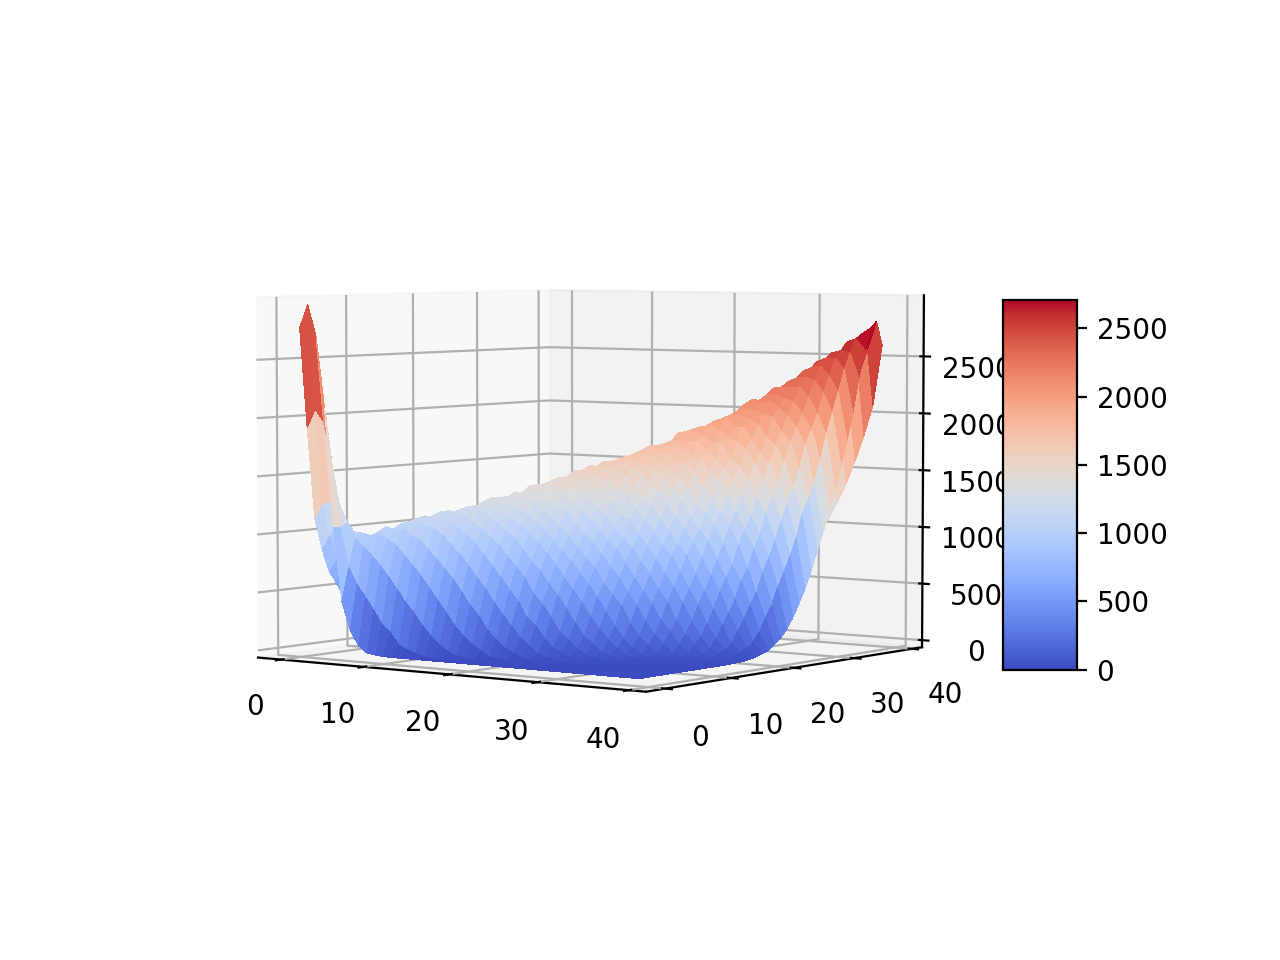

In [53]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, countIndexByRisksArray, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [ ]:
from matplotlib.colors import LightSource

In [ ]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

ls = LightSource(270, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(countByRisksArray, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(X,Y,countByRisksArray, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

plt.show()

In [194]:
demQuantiles = allAgesDF.demRisk.quantile(np.arange(0, 1+increment, increment).tolist())
cvQuantiles = allAgesDF.cvRisk.quantile(np.arange(0, 1+increment, increment).tolist())
quantileDF = pd.DataFrame(index=demQuantiles.index, data={'dementia' : demQuantiles.values, 'cv' : cvQuantiles.values})
#quantileDF

In [179]:
quantileDF.loc[0,"dementia"]=0
quantileDF.loc[0,"cv"]=0
quantileDF

,dementia,cv
0.000,0.000000,0.000000
0.025,0.000006,0.000065
0.050,0.000013,0.000128
0.075,0.000024,0.000208
0.100,0.000041,0.000301
0.125,0.000064,0.000409
0.150,0.000096,0.000529
0.175,0.000136,0.000663
0.200,0.000187,0.000812
0.225,0.000250,0.000975


In [180]:
quantileDF.shape

(41, 2)

In [137]:
#allAgesDF.demRisk.describe(), allAgesDF.cvRisk.describe()

In [181]:
qqcategoriesToInclude.reset_index(drop=True,inplace=True)

In [182]:
qqcategoriesToInclude.drop(["ageCount"],inplace=True,axis=1)

/var/folders/gw/n7s8sshd3j15_qhx38pz00x40000gq/T/ipykernel_57823/2693971817.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqcategoriesToInclude.drop(["ageCount"],inplace=True,axis=1)


In [195]:
qqcategoriesToInclude["demRiskLowerLimit"] = quantileDF.iloc[
                                                qqcategoriesToInclude["demRisk"].to_list()
                                            ]["dementia"].reset_index(drop=True)
qqcategoriesToInclude["cvRiskLowerLimit"] = quantileDF.iloc[
                                                qqcategoriesToInclude["cvRisk"].to_list()
                                            ]["cv"].reset_index(drop=True)

/var/folders/gw/n7s8sshd3j15_qhx38pz00x40000gq/T/ipykernel_57823/3908007400.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqcategoriesToInclude["demRiskLowerLimit"] = quantileDF.iloc[
/var/folders/gw/n7s8sshd3j15_qhx38pz00x40000gq/T/ipykernel_57823/3908007400.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qqcategoriesToInclude["cvRiskLowerLimit"] = quantileDF.iloc[


In [196]:
qqcategoriesToInclude.transpose().head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942
demRisk,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0

In [185]:
qqcategoriesToInclude.transpose().shape

(4, 943)

In [186]:
qqcategoriesToInclude.head()

,demRisk,cvRisk,demRiskLowerLimit,cvRiskLowerLimit
0,0,0,0.0,0.000000
1,0,1,0.0,0.000065
2,0,2,0.0,0.000128
3,0,3,0.0,0.000208
4,0,4,0.0,0.000301


In [187]:
qqcategoriesToInclude.shape

(943, 4)

In [197]:
qqcategoriesToInclude.to_csv(dataDir + "/dementiaAndCVQuantilesToInclude.csv")

In [198]:
quantileDF.to_csv(dataDir + "/dementiaAndCVQuantileThresholds.csv")

In [190]:
demQuantileNumberForQuantile

{Interval(-0.0009999712, 5.99e-06, closed='right'): 0,
 Interval(5.99e-06, 1.28e-05, closed='right'): 1,
 Interval(1.28e-05, 2.37e-05, closed='right'): 2,
 Interval(2.37e-05, 4.05e-05, closed='right'): 3,
 Interval(4.05e-05, 6.42e-05, closed='right'): 4,
 Interval(6.42e-05, 9.55e-05, closed='right'): 5,
 Interval(9.55e-05, 0.000136, closed='right'): 6,
 Interval(0.000136, 0.000187, closed='right'): 7,
 Interval(0.000187, 0.00025, closed='right'): 8,
 Interval(0.00025, 0.000328, closed='right'): 9,
 Interval(0.000328, 0.000424, closed='right'): 10,
 Interval(0.000424, 0.000541, closed='right'): 11,
 Interval(0.000541, 0.000683, closed='right'): 12,
 Interval(0.000683, 0.000853, closed='right'): 13,
 Interval(0.000853, 0.00106, closed='right'): 14,
 Interval(0.00106, 0.0013, closed='right'): 15,
 Interval(0.0013, 0.00159, closed='right'): 16,
 Interval(0.00159, 0.00194, closed='right'): 17,
 Interval(0.00194, 0.00235, closed='right'): 18,
 Interval(0.00235, 0.00284, closed='right'): 19,


In [192]:
import pickle
with open(dataDir + "/demQuantileNumberForQuantile.pickle","wb") as file:
    pickle.dump(demQuantileNumberForQuantile,file)

In [193]:
with open(dataDir + "/cvQuantileNumberForQuantile.pickle","wb") as file:
    pickle.dump(cvQuantileNumberForQuantile,file)